# Chatterbox Turbo TTS Debugging Notebook

This notebook helps debug Chatterbox Turbo TTS audio generation issues.

**Run on Google Colab with GPU enabled:**
- Runtime → Change runtime type → GPU (T4 is sufficient)

**You will need:**
- Hugging Face token with read access

## 1. Setup and Installation

In [1]:
!git clone https://github.com/ahmadshajhan/chatterbox.git
%cd chatterbox
!pip install -e .

fatal: destination path 'chatterbox' already exists and is not an empty directory.
/content/chatterbox
Obtaining file:///content/chatterbox
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for chatterbox-tts (pyproject.toml) ... done
  Created wheel for chatterbox-tts: filename=chatterbox_tts-0.1.6-0.editable-py3-none-any.whl size=6837 sha256=02022e5364ccc660d9c0480c8b904947ecadd98381af561f8ca31d9eda8b322c
  Stored in directory: /tmp/pip-ephem-wheel-cache-kc3_6lfw/wheels/18/55/79/47131f0a1fd00b4fdf3d33198ccc0fe2d12c91f3c108710760
Successfully built chatterbox-tts
  Attempting uninstall: chatterbox-tts
    Found existing installation: chatterbox-tts 0.1.6
    Uninstalling chatterbox-tts-0.1.6:
      Successfully uninstalled chatterbox-tts-0.1.6


In [9]:
!pip install -q huggingface-hub torchaudio matplotlib librosa soundfile

In [4]:
from huggingface_hub import login
from getpass import getpass

hf_token = getpass("Enter your Hugging Face token: ")
login(token=hf_token)
print("Authenticated with Hugging Face")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


HTTPError: Invalid user token.

In [10]:
import torch
import torchaudio as ta
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import soundfile as sf
from IPython.display import Audio, display

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4


## 2. Load Chatterbox Turbo Model

In [6]:
from chatterbox.tts_turbo import ChatterboxTurboTTS

print("Loading Chatterbox Turbo TTS model...")
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ChatterboxTurboTTS.from_pretrained(device=device)
print(f"Model loaded on {device}")
print(f"Sample rate: {model.sr} Hz")

Loading Chatterbox Turbo TTS model...


Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

conds.pt:   0%|          | 0.00/169k [00:00<?, ?B/s]

s3gen.safetensors:   0%|          | 0.00/1.06G [00:00<?, ?B/s]

s3gen_meanflow.safetensors:   0%|          | 0.00/1.06G [00:00<?, ?B/s]

t3_turbo_v1.safetensors:   0%|          | 0.00/1.92G [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/470 [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

ve.safetensors:   0%|          | 0.00/5.70M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/diffusers/models/lora.py:393: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)


loaded PerthNet (Implicit) at step 250,000
Model loaded on cuda
Sample rate: 24000 Hz


In [39]:
# Get the tokenizer from the model
# The tokenizer is in the text_encoder's tokenizer attribute
try:
    # Try different possible paths to the tokenizer
    if hasattr(model, 'text_encoder'):
        tokenizer = model.text_encoder.tokenizer
    elif hasattr(model, 'tokenizer'):
        tokenizer = model.tokenizer
    elif hasattr(model, 'text_embedder') and hasattr(model.text_embedder, 'tokenizer'):
        tokenizer = model.text_embedder.tokenizer
    else:
        # Explore model structure to find tokenizer
        print("Exploring model structure...")
        print(f"Model type: {type(model)}")
        print(f"Model attributes: {[attr for attr in dir(model) if not attr.startswith('_')][:20]}")
        
        # Try to find anything with tokenizer in it
        tokenizer_attrs = [attr for attr in dir(model) if 'token' in attr.lower() or 'text' in attr.lower()]
        print(f"Tokenizer-related attributes: {tokenizer_attrs}")
        
        # Check if model has components with tokenizers
        for attr_name in dir(model):
            if not attr_name.startswith('_'):
                attr = getattr(model, attr_name, None)
                if attr and hasattr(attr, 'tokenizer'):
                    print(f"Found tokenizer in: model.{attr_name}.tokenizer")
                    tokenizer = attr.tokenizer
                    break
        else:
            raise AttributeError("Could not find tokenizer in model")
    
    print(f"Tokenizer loaded: {type(tokenizer).__name__}")
    
    # Test token counting
    test_text = "Hello, this is a test."
    test_tokens = tokenizer.encode(test_text)
    print(f"Test: '{test_text}' = {len(test_tokens)} tokens")
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    print("\nPlease run the cell again or check model structure.")

Tokenizer loaded: GPT2TokenizerFast
Test: 'Hello, this is a test.' = 7 tokens


## 3. Helper Functions

In [34]:
def visualize_audio(wav, sr, title="Audio Waveform"):
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    if isinstance(wav, torch.Tensor):
        wav_np = wav.cpu().numpy().squeeze()
    else:
        wav_np = wav.squeeze()
    
    axes[0].plot(wav_np)
    axes[0].set_title(f"{title} - Waveform")
    axes[0].set_xlabel("Sample")
    axes[0].set_ylabel("Amplitude")
    axes[0].grid(True, alpha=0.3)
    
    D = librosa.amplitude_to_db(np.abs(librosa.stft(wav_np)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[1])
    axes[1].set_title(f"{title} - Spectrogram")
    fig.colorbar(img, ax=axes[1], format="%+2.0f dB")
    
    plt.tight_layout()
    plt.show()
    
    print(f"Duration: {len(wav_np) / sr:.2f}s")
    print(f"Shape: {wav_np.shape}")
    print(f"Amplitude: [{wav_np.min():.4f}, {wav_np.max():.4f}]")
    print(f"Mean: {wav_np.mean():.4f}, Std: {wav_np.std():.4f}")

def play_audio(wav, sr):
    if isinstance(wav, torch.Tensor):
        wav_np = wav.cpu().numpy().squeeze()
    else:
        wav_np = wav.squeeze()
    display(Audio(wav_np, rate=sr))

def save_audio(wav, sr, filename):
    if isinstance(wav, torch.Tensor):
        wav_np = wav.cpu().numpy().squeeze()
    else:
        wav_np = wav.squeeze()
    sf.write(filename, wav_np, sr)
    print(f"Saved to {filename}")

In [35]:
def count_tokens(text, tokenizer):
    """Count tokens in text using model's tokenizer."""
    tokens = tokenizer.encode(text)
    return len(tokens)

def split_text_into_chunks(text, tokenizer, max_tokens=950):
    """Split text into chunks at sentence boundaries, keeping under max_tokens.
    
    Args:
        text: Input text to split
        tokenizer: Model's tokenizer
        max_tokens: Maximum tokens per chunk (default 950 to leave buffer)
    
    Returns:
        List of text chunks
    """
    import re
    
    # Split into sentences (basic approach)
    sentences = re.split(r'(?<=[.!?])\s+', text)
    
    chunks = []
    current_chunk = []
    current_tokens = 0
    
    for sentence in sentences:
        sentence_tokens = count_tokens(sentence, tokenizer)
        
        # If single sentence exceeds limit, split it further by commas
        if sentence_tokens > max_tokens:
            # Try splitting by commas
            parts = re.split(r'(?<=,)\s+', sentence)
            for part in parts:
                part_tokens = count_tokens(part, tokenizer)
                if current_tokens + part_tokens > max_tokens:
                    if current_chunk:
                        chunks.append(' '.join(current_chunk))
                        current_chunk = [part]
                        current_tokens = part_tokens
                    else:
                        # Part is still too long, force split
                        chunks.append(part)
                else:
                    current_chunk.append(part)
                    current_tokens += part_tokens
        else:
            # Check if adding this sentence exceeds limit
            if current_tokens + sentence_tokens > max_tokens:
                if current_chunk:
                    chunks.append(' '.join(current_chunk))
                current_chunk = [sentence]
                current_tokens = sentence_tokens
            else:
                current_chunk.append(sentence)
                current_tokens += sentence_tokens
    
    # Add remaining chunk
    if current_chunk:
        chunks.append(' '.join(current_chunk))
    
    return chunks

def generate_long_audio(text, model, tokenizer, **kwargs):
    """Generate audio for text longer than 1000 tokens by chunking.
    
    Args:
        text: Input text (any length)
        model: Chatterbox model
        tokenizer: Model's tokenizer
        **kwargs: Parameters to pass to model.generate()
    
    Returns:
        Concatenated audio waveform
    """
    total_tokens = count_tokens(text, tokenizer)
    
    if total_tokens <= 950:
        # Text is short enough, generate directly
        print(f"Text has {total_tokens} tokens, generating directly...")
        return model.generate(text, **kwargs)
    
    # Text is too long, need to chunk
    print(f"Text has {total_tokens} tokens (exceeds 1000 limit)")
    chunks = split_text_into_chunks(text, tokenizer, max_tokens=950)
    print(f"Split into {len(chunks)} chunks")
    
    audio_chunks = []
    for i, chunk in enumerate(chunks, 1):
        chunk_tokens = count_tokens(chunk, tokenizer)
        print(f"  Chunk {i}/{len(chunks)}: {chunk_tokens} tokens, {len(chunk)} chars")
        wav = model.generate(chunk, **kwargs)
        audio_chunks.append(wav)
    
    # Concatenate audio chunks
    print("Concatenating audio chunks...")
    if isinstance(audio_chunks[0], torch.Tensor):
        concatenated = torch.cat(audio_chunks, dim=-1)
    else:
        concatenated = np.concatenate(audio_chunks, axis=-1)
    
    return concatenated

print("Chunking functions defined")

Chunking functions defined


## 4. Test 1: Simple Text with Default Parameters

Text: Hello, this is a test.
Using default parameters


  4%|▍         | 43/1000 [00:00<00:17, 55.72it/s]


S3 Token -> Mel Inference...


100%|██████████| 2/2 [00:00<00:00, 16.93it/s]


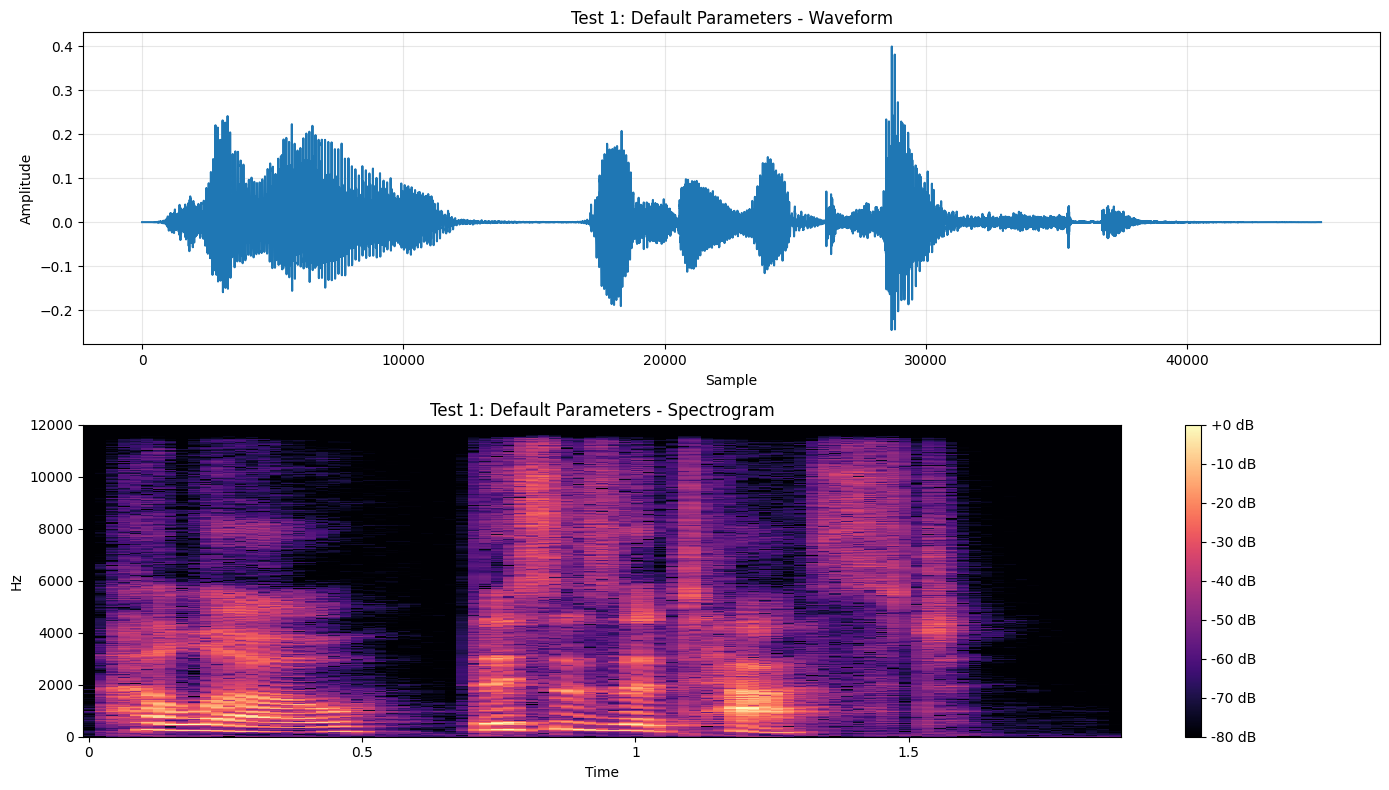

Duration: 1.88s
Shape: (45120,)
Amplitude: [-0.2454, 0.3994]
Mean: -0.0000, Std: 0.0354


Saved to test1_default.wav


In [12]:
text = "Hello, this is a test."
print(f"Text: {text}")
print("Using default parameters")

wav = model.generate(text)

visualize_audio(wav, model.sr, "Test 1: Default Parameters")
play_audio(wav, model.sr)
save_audio(wav, model.sr, "test1_default.wav")

## 5. Test 2: Simple Text with Your Parameters

Text: Hello, this is a test.
Using: exaggeration=0.5, cfg_weight=0.5


  5%|▌         | 50/1000 [00:00<00:16, 56.20it/s]


S3 Token -> Mel Inference...


100%|██████████| 2/2 [00:00<00:00, 18.06it/s]


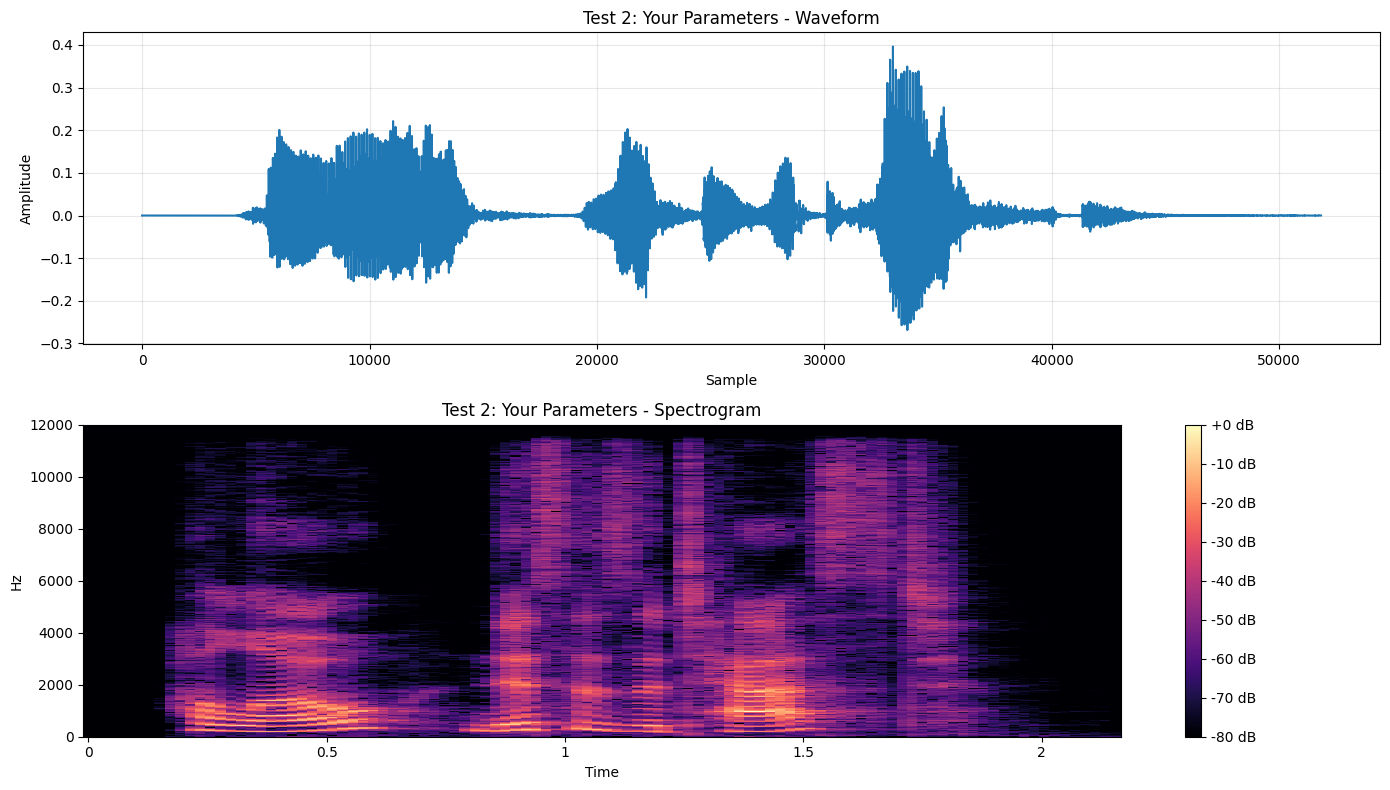

Duration: 2.16s
Shape: (51840,)
Amplitude: [-0.2686, 0.3963]
Mean: -0.0000, Std: 0.0409


Saved to test2_your_params.wav


In [13]:
text = "Hello, this is a test."
print(f"Text: {text}")
print("Using: exaggeration=0.5, cfg_weight=0.5")

wav = model.generate(text, exaggeration=0.5, cfg_weight=0.5, temperature=1.0)

visualize_audio(wav, model.sr, "Test 2: Your Parameters")
play_audio(wav, model.sr)
save_audio(wav, model.sr, "test2_your_params.wav")

## 6. Test 3: Check Model Parameters

In [14]:
import inspect

signature = inspect.signature(model.generate)
print("ChatterboxTurboTTS.generate() signature:")
print(signature)
print("\nParameters:")
for param_name, param in signature.parameters.items():
    default = param.default if param.default != inspect.Parameter.empty else "required"
    print(f"  {param_name}: {default}")

ChatterboxTurboTTS.generate() signature:
(text, repetition_penalty=1.2, min_p=0.0, top_p=0.95, audio_prompt_path=None, exaggeration=0.0, cfg_weight=0.0, temperature=0.8, top_k=1000, norm_loudness=True)

Parameters:
  text: required
  repetition_penalty: 1.2
  min_p: 0.0
  top_p: 0.95
  audio_prompt_path: None
  exaggeration: 0.0
  cfg_weight: 0.0
  temperature: 0.8
  top_k: 1000
  norm_loudness: True


## 7. Test 4: Different Parameter Combinations

In [36]:
import re

def preprocess_text(text):
    """Preprocess text for better TTS quality.
    
    Removes formatting issues like excessive indentation and hard line breaks.
    """
    lines = text.split('\n')
    paragraphs = []
    current = []
    
    for line in lines:
        cleaned = line.strip()
        if not cleaned:
            if current:
                paragraphs.append(' '.join(current))
                current = []
        else:
            current.append(cleaned)
    
    if current:
        paragraphs.append(' '.join(current))
    
    result = '\n\n'.join(paragraphs)
    return re.sub(r' +', ' ', result)

print("Preprocessing function defined")

Preprocessing function defined


In [ ]:
raw_text = """We loitered the morning away in the garden. Stanley Hopkins had
gone down to the village to look into some rumours of a strange
woman who had been seen by some children on the Chatham Road the
previous morning. As to my friend, all his usual energy seemed to
have deserted him. I had never known him handle a case in such a
half-hearted fashion. Even the news brought back by Hopkins that
he had found the children, and that they had undoubtedly seen a
woman exactly corresponding with Holmes's description, and
wearing either spectacles or eyeglasses, failed to rouse any sign
of keen interest. He was more attentive when Susan, who waited
upon us at lunch, volunteered the information that she believed
Mr. Smith had been out for a walk yesterday morning, and that he
had only returned half an hour before the tragedy occurred. I
could not myself see the bearing of this incident, but I clearly
perceived that Holmes was weaving it into the general scheme
which he had formed in his brain. Suddenly he sprang from his
chair and glanced at his watch. Two o'clock, gentlemen, said
he. We must go up and have it out with our friend, the professor.

The old man had just finished his lunch, and certainly his empty
dish bore evidence to the good appetite with which his
housekeeper had credited him. He was, indeed, a weird figure as
he turned his white mane and his glowing eyes towards us. The
eternal cigarette smouldered in his mouth. He had been dressed
and was seated in an armchair by the fire.

Well, Mr. Holmes, have you solved this mystery yet? He shoved
the large tin of cigarettes which stood on a table beside him
towards my companion. Holmes stretched out his hand at the same
moment, and between them they tipped the box over the edge. For a
minute or two we were all on our knees retrieving stray
cigarettes from impossible places. When we rose again, I observed
Holmes's eyes were shining and his cheeks tinged with colour.
Only at a crisis have I seen those battle-signals flying.

Yes, said he, I have solved it.

Stanley Hopkins and I stared in amazement. Something like a sneer
quivered over the gaunt features of the old professor."""

cleaned = preprocess_text(raw_text)

print("Raw text (first 100 chars):")
print(repr(raw_text[:100]))
print("\nCleaned text (first 100 chars):")
print(repr(cleaned[:100]))
print(f"\nText length: {len(cleaned)} characters")

In [ ]:
print("Generating with cleaned text...")
wav_clean = generate_long_audio(cleaned, model, tokenizer, exaggeration=0.5, cfg_weight=0.5)
save_audio(wav_clean, model.sr, "test5_cleaned.wav")
play_audio(wav_clean, model.sr)

In [ ]:
print("Generating with raw text...")
wav_raw = generate_long_audio(raw_text, model, tokenizer, exaggeration=0.5, cfg_weight=0.5)
save_audio(wav_raw, model.sr, "test5_raw.wav")
play_audio(wav_raw, model.sr)

In [33]:
print("Generating with cleaned text...")
wav_clean = model.generate(cleaned, exaggeration=0.5, cfg_weight=0.5)
save_audio(wav_clean, model.sr, "test5_cleaned.wav")
play_audio(wav_clean, model.sr)

Generating with cleaned text...


 77%|███████▋  | 766/1000 [00:12<00:03, 59.46it/s]


S3 Token -> Mel Inference...


100%|██████████| 2/2 [00:00<00:00,  3.44it/s]


Saved to test5_cleaned.wav


In [19]:
print("Generating with raw text...")
wav_raw = model.generate(raw_text, exaggeration=0.5, cfg_weight=0.5)
save_audio(wav_raw, model.sr, "test5_raw.wav")
play_audio(wav_raw, model.sr)

Generating with raw text...


 22%|██▏       | 224/1000 [00:04<00:15, 51.45it/s]


S3 Token -> Mel Inference...


100%|██████████| 2/2 [00:00<00:00, 10.90it/s]


Saved to test5_raw.wav


In [ ]:
## 11. Diagnostic Summary

print("="*60)
print("DIAGNOSTIC QUESTIONS")
print("="*60)
print("1. Does Test 1 sound good?")
print("   YES = Default parameters work")
print("   NO = Model issue")
print("")
print("2. Does Test 2 sound good?")
print("   YES = Your parameters are fine")
print("   NO = Parameters too low")
print("")
print("3. Which Test 4 sounds best?")
print("   Use those parameters!")
print("")
print("4. Test 5: Cleaned better than raw?")
print("   YES = Preprocessing helps")
print("   NO = Not a preprocessing issue")
print("")
print("5. Are Test 6 short sentences clear?")
print("   YES but long text bad = Length issue")
print("")
print("6. Does Test 7 long text sound complete?")
print("   YES = Chunking works!")
print("   NO = Check token count and chunk boundaries")
print("="*60)
print("")
print("NOTE: Chatterbox has a 1000 token limit.")
print("Test 7 demonstrates automatic chunking for longer text.")
print("="*60)

## 12. List Generated Files

In [ ]:
sentences = [
    "Hello.",
    "This is a test.",
    "The weather is nice today.",
]

for i, s in enumerate(sentences, 1):
    print(f"\nTest {i}: {s}")
    wav = model.generate(s, exaggeration=0.5, cfg_weight=0.5)
    save_audio(wav, model.sr, f"test6_short_{i}.wav")
    play_audio(wav, model.sr)

## 10. Diagnostic Summary

In [ ]:
print("="*60)
print("DIAGNOSTIC QUESTIONS")
print("="*60)
print("1. Does Test 1 sound good?")
print("   YES = Default parameters work")
print("   NO = Model issue")
print("")
print("2. Does Test 2 sound good?")
print("   YES = Your parameters are fine")
print("   NO = Parameters too low")
print("")
print("3. Which Test 4 sounds best?")
print("   Use those parameters!")
print("")
print("4. Test 5: Cleaned better than raw?")
print("   YES = Preprocessing helps")
print("   NO = Not a preprocessing issue")
print("")
print("5. Are Test 6 short sentences clear?")
print("   YES but long text bad = Length issue")
print("="*60)

## 11. List Generated Files

In [ ]:
import glob
import os

files = sorted(glob.glob("test*.wav"))
print(f"Generated {len(files)} test files:\n")
for f in files:
    size = os.path.getsize(f) / 1024
    print(f"  {f} ({size:.1f} KB)")
print("\nDownload from file browser on left")